# Import modules

In [6]:
from sunpy.net import Fido, attrs as a
import sunpy.io.cdf as cdf
from sunpy.timeseries import GenericTimeSeries
import sunpy_soar
import numpy as np

Exception ignored in: <function CDF.__del__ at 0x000002B8EFA63280>
Traceback (most recent call last):
  File "c:\Users\Ronan\Anaconda3\envs\belfast_data\lib\site-packages\cdflib\cdfread.py", line 152, in __del__
    os.remove(self.temp_file)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'C:\\Users\\Ronan\\AppData\\Local\\Temp\\tmp8t_oqjkc.cdf'


# Load the data

In [8]:
# Create search attributes
instrument = a.Instrument('MAG')
time = a.Time('2021-02-01', '2021-02-03')
level = a.Level(2)
product = a.soar.Product('MAG-RTN-NORMAL')

# Do search
result = Fido.search(time & level & product)
print(result)


Results from 1 Provider:

3 Results from the SOARClient:

Instrument  Data product  Level ...         End time        Filesize
                                ...                          Mbyte  
---------- -------------- ----- ... ----------------------- --------
       MAG MAG-RTN-NORMAL    L2 ... 2021-02-03 00:00:00.000     8.57
       MAG MAG-RTN-NORMAL    L2 ... 2021-02-04 00:00:00.000      4.4
       MAG MAG-RTN-NORMAL    L2 ... 2021-02-02 00:00:00.000    8.174




In [9]:
# Download files
files = Fido.fetch(result)

Files Downloaded: 100%|██████████| 3/3 [00:00<00:00, 10.24file/s]


Loading C:\Users\Ronan\sunpy\data\solo_L2_mag-rtn-normal_20210202_V02.cdf
Loading C:\Users\Ronan\sunpy\data\solo_L2_mag-rtn-normal_20210203_V02.cdf


Exception ignored in: <function CDF.__del__ at 0x000002B8EFA63280>
Traceback (most recent call last):
  File "c:\Users\Ronan\Anaconda3\envs\belfast_data\lib\site-packages\cdflib\cdfread.py", line 152, in __del__
    os.remove(self.temp_file)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'C:\\Users\\Ronan\\AppData\\Local\\Temp\\tmp4ajov09f.cdf'
Exception ignored in: <function CDF.__del__ at 0x000002B8EFA63280>
Traceback (most recent call last):
  File "c:\Users\Ronan\Anaconda3\envs\belfast_data\lib\site-packages\cdflib\cdfread.py", line 152, in __del__
    os.remove(self.temp_file)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'C:\\Users\\Ronan\\AppData\\Local\\Temp\\tmpkvuhc1gk.cdf'


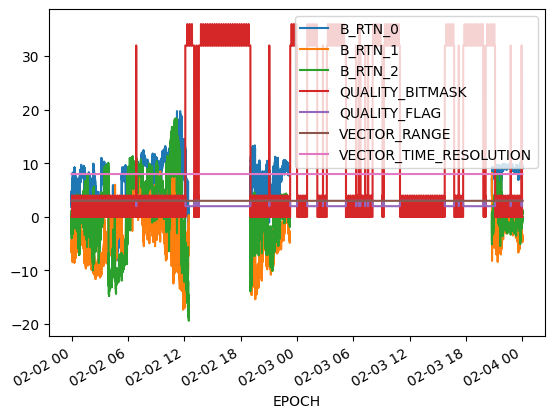

In [10]:
for i, file in enumerate(files[:2]):
    print(f"Loading {file}")
    
    # this stupid function does have an __enter__ class
    # with cdf.read_cdf(file) as ts: 
    
    ts = cdf.read_cdf(file)

    if len(ts) <= 1:
        #just one timeseries so extract this
        ts = ts[0]
    
    if i < 1:
        data = ts
    else:
        data = data.concatenate(ts)

data = data.sort_index()
data.peek()

<sunpy.timeseries.timeseriesbase.GenericTimeSeries object at 0x00000221E98ABD30>
|-------------------------------------------------------------------------------------------------|
|TimeRange                  | Columns         | Meta                                              |
|-------------------------------------------------------------------------------------------------|
|2021-02-09T00:00:00.080003 | B_RTN_0         | Project: Solar Orbiter                            |
|            to             | B_RTN_1         | Source_name: SOLO>Solar Orbiter                   |
|2021-02-09T23:59:59.938996 | B_RTN_2         | Discipline: Space Physics>Interplanetary Studies  |
|                           | QUALITY_BITMASK | Data_type: L2>Level 2 Calibrated Data             |
|                           | QUALITY_FLAG    | Descriptor: MAG>Magnetometer                      |
|                           | VECTOR_RANGE    | Data_version: 02                                  |
|                           | VECTOR_TIME_RES | Software_version: 2.2                             |
|                           |                 | Skeleton_version: 11                              |
|                           |                 | PI_name: T. Horbury                               |
|                           |                 | PI_affiliation: The Blackett Laboratory, Imperial |
|                           |                 | ...                                               |
|-------------------------------------------------------------------------------------------------|

                              B_RTN_0   B_RTN_1   B_RTN_2  QUALITY_BITMASK  \
EPOCH                                                                        
2021-02-09 00:00:00.080003  -7.626987 -3.977302  6.374979                0   
2021-02-09 00:00:00.204997  -7.606572 -3.940607  6.390006                0   
2021-02-09 00:00:00.330002  -7.630965 -3.894173  6.286361                0   
2021-02-09 00:00:00.454996  -7.747252 -3.843424  6.128484                0   
2021-02-09 00:00:00.580000  -7.797104 -3.859358  6.081920                0   
...                               ...       ...       ...              ...   
2021-02-09 23:59:59.438999 -11.003886  1.167840  5.770323               32   
2021-02-09 23:59:59.564003 -11.011609  1.163783  5.757525               32   
2021-02-09 23:59:59.688997 -11.021178  1.137571  5.730725               32   
2021-02-09 23:59:59.814002 -11.025812  1.142247  5.712272               32   
2021-02-09 23:59:59.938996 -11.063711  1.148322  5.726668               32   

                            QUALITY_FLAG  VECTOR_RANGE  VECTOR_TIME_RESOLUTION  
EPOCH                                                                           
2021-02-09 00:00:00.080003             3             3                     8.0  
2021-02-09 00:00:00.204997             3             3                     8.0  
2021-02-09 00:00:00.330002             3             3                     8.0  
2021-02-09 00:00:00.454996             3             3                     8.0  
2021-02-09 00:00:00.580000             3             3                     8.0  
...                                  ...           ...                     ...  
2021-02-09 23:59:59.438999             2             3                     8.0  
2021-02-09 23:59:59.564003             2             3                     8.0  
2021-02-09 23:59:59.688997             2             3                     8.0  
2021-02-09 23:59:59.814002             2             3                     8.0  
2021-02-09 23:59:59.938996             2             3                     8.0  

[691208 rows x 7 columns]
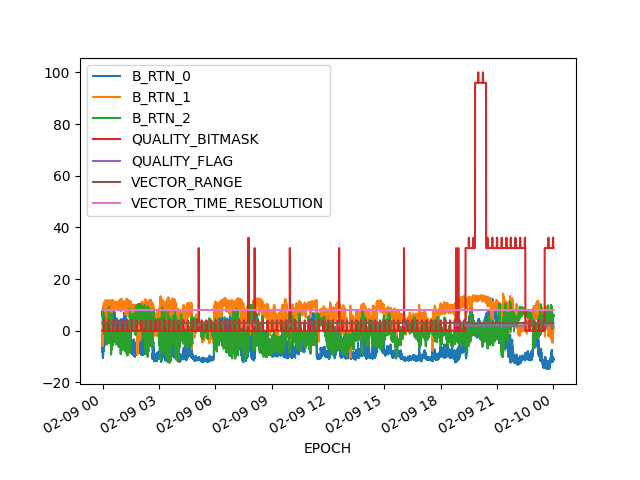

In [7]:
ts